In [1]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:

# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints


 
urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   
totalurl = 'https://api.eia.gov/v2/total-energy/data/'

# Parameters

WTI = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RWTC",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

Brent = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RBRTE",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}


Storage = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[msn][0]": "COSXPUS",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

Imports = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[msn][0]": "COIMPUS",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

response2 = requests.get(urlPrice, params=WTI)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'WTI'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(urlPrice, params=Brent)
data2 = response2.json()
df8 = pd.DataFrame(data2['response']['data'])
df8 = df8[['period', 'value']]
df8.rename(columns={'value': 'Brent'}, inplace=True)
df8.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(totalurl, params=Storage)
data2 = response2.json()
df7 = pd.DataFrame(data2['response']['data'])
df7 = df7[['period', 'value']]
df7.rename(columns={'value': 'Store'}, inplace=True)
df7.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(totalurl, params=Imports)
data2 = response2.json()
df1 = pd.DataFrame(data2['response']['data'])
df1 = df1[['period', 'value']]
df1.rename(columns={'value': 'Imports'}, inplace=True)
df1.rename(columns={'period': 'ds'}, inplace=True)


for df in [df1, df6, df7, df8]:
    df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()
df_merged = df7
df_merged = pd.merge(df_merged, df6, on='ds', how='outer')
df_merged = pd.merge(df_merged, df8, on='ds', how='outer')
df_merged = pd.merge(df_merged, df1, on='ds', how='outer')




print(df_merged.tail(20))

df_merged.to_pickle("Imports.pkl")

            ds    Store    WTI  Brent   Imports
166 2023-11-01  441.838  77.69  82.94  6926.467
167 2023-12-01  426.491   71.9  77.63  6421.774
168 2024-01-01  427.857  74.15  80.12  6627.323
169 2024-02-01  447.929  77.25  83.48  6537.103
170 2024-03-01  447.206  81.28  85.41  6196.194
171 2024-04-01  463.842  85.35  89.94  6578.033
172 2024-05-01  454.548  80.02  81.75  7055.484
173 2024-06-01  440.151  79.77  82.25  6664.133
174 2024-07-01  427.207   81.8  85.15  7122.839
175 2024-08-01   417.35  76.68  80.36  6325.419
176 2024-09-01  415.933  70.24  74.02  6455.933
177 2024-10-01  423.629  71.99  75.63  6355.677
178 2024-11-01  421.308  69.95  74.35  6577.533
179 2024-12-01  413.734  70.12  73.86  6557.323
180 2025-01-01  418.782  75.74  79.27  6649.355
181 2025-02-01  429.786  71.53  75.44  6044.964
182 2025-03-01  431.688  68.24  72.73  5756.032
183 2025-04-01  438.666  63.54  68.13    5817.3
184 2025-05-01  435.018  62.17  64.45  6154.742
185 2025-06-01      NaN  68.17  71.44   

In [3]:
# Approximate current month pricing data
df = pd.read_pickle("Imports.pkl")
df['ds'] = pd.to_datetime(df['ds'])

# === Step 1: Get current month start ===
last_reported_month = df['ds'].max()
next_month_start = last_reported_month + relativedelta(months=1)


# === Step 2: Check if row exists for current month ===
if next_month_start not in df['ds'].values:
    
    # === Step 3: Get 30-day average prices from yfinance ===
    today = datetime.today()
    start_date = today - timedelta(days=30)

    wti = yf.download("CL=F", start=start_date, end=today)['Close'].dropna()
    wti_avg = wti.mean().item()

    brent = yf.download('BZ=F', start=start_date, end=today)['Close'].dropna()
    brent_avg = brent.mean().item()

    # === Step 4: Create new row ===
    new_row = {
        'ds': next_month_start,
        'WTI': wti_avg,
        'Brent': brent_avg,
        # Fill other columns with NaN
        'Store': None,
    }

    # === Step 5: Append to DataFrame ===
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
 


df.to_pickle("Imports1.pkl")

print(df.tail(20))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


            ds    Store        WTI      Brent   Imports
167 2023-12-01  426.491       71.9      77.63  6421.774
168 2024-01-01  427.857      74.15      80.12  6627.323
169 2024-02-01  447.929      77.25      83.48  6537.103
170 2024-03-01  447.206      81.28      85.41  6196.194
171 2024-04-01  463.842      85.35      89.94  6578.033
172 2024-05-01  454.548      80.02      81.75  7055.484
173 2024-06-01  440.151      79.77      82.25  6664.133
174 2024-07-01  427.207       81.8      85.15  7122.839
175 2024-08-01   417.35      76.68      80.36  6325.419
176 2024-09-01  415.933      70.24      74.02  6455.933
177 2024-10-01  423.629      71.99      75.63  6355.677
178 2024-11-01  421.308      69.95      74.35  6577.533
179 2024-12-01  413.734      70.12      73.86  6557.323
180 2025-01-01  418.782      75.74      79.27  6649.355
181 2025-02-01  429.786      71.53      75.44  6044.964
182 2025-03-01  431.688      68.24      72.73  5756.032
183 2025-04-01  438.666      63.54      68.13   

In [4]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'Store'
EXOG_COLS = ['WTI', 'Brent']
df = pd.read_pickle("Imports1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.6,
    colsample_bytree=1,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))

df_full = df

#=============================#
#    Optimize Parameters      #
#=============================#

from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      5.99
RMSE (Root Mean Squared Error): 8.03
MAPE (Mean Absolute % Error):   1.38%

=== Final df with historical + forecasted values ===
        ds      Store
2024-12-01 413.734000
2025-01-01 418.782000
2025-02-01 429.786000
2025-03-01 431.688000
2025-04-01 438.666000
2025-05-01 435.018000
2025-06-01 426.260773
2025-07-01 426.868774

=== Best Parameters Found ===
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}


In [5]:
df = pd.read_pickle("Imports1.pkl")
df = df[['ds', 'Imports', 'Brent', 'WTI']].copy()

df_full = pd.merge(df_full, df, on='ds', how='outer')



df_full = df_full[['ds', 'WTI', 'Brent', 'Store', 'Imports']].copy()


# Check if last row (excluding 'ds') is all NaN
if not df_full.iloc[-1].drop(labels='ds').isna().all():
    next_date = df_full['ds'].max() + relativedelta(months=1)
    new_row = {col: pd.NA for col in df_full.columns}
    new_row['ds'] = next_date
    df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)

print(df_full.tail())

            ds        WTI      Brent       Store   Imports
183 2025-04-01      63.54      68.13  438.666000    5817.3
184 2025-05-01      62.17      64.45  435.018000  6154.742
185 2025-06-01      68.17      71.44  426.260773       NaN
186 2025-07-01  68.232104  70.264738  426.868774       NaN
187 2025-08-01        NaN        NaN         NaN       NaN


/var/folders/1v/qxw436v577vd4tnnpxrghrpw0000gn/T/ipykernel_63588/1834859326.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)



=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      284.94
RMSE (Root Mean Squared Error): 344.61
MAPE (Mean Absolute % Error):   4.40%


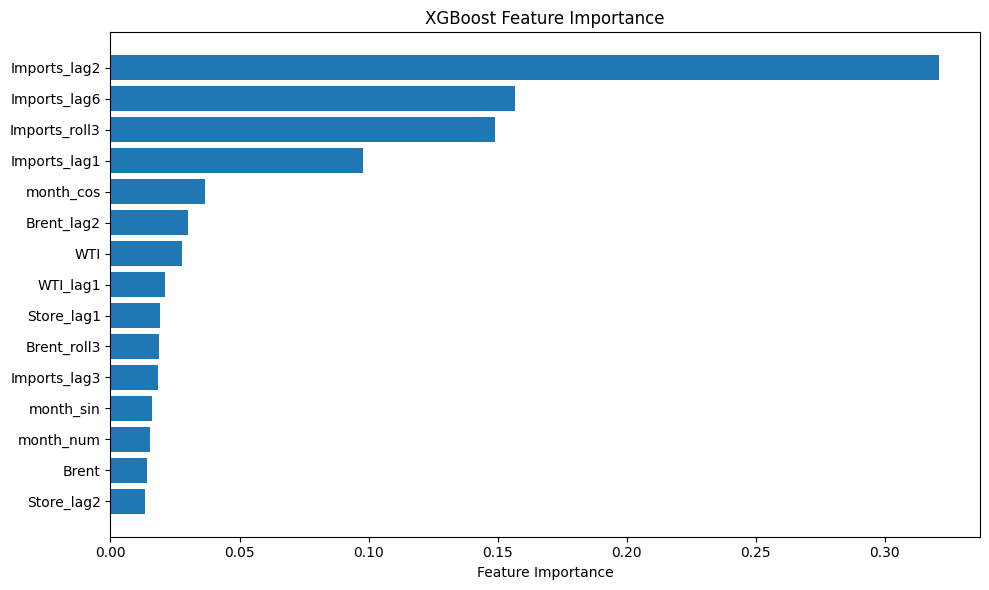


=== Final df with historical + forecasted values ===
        ds     Imports
2025-01-01 6649.355000
2025-02-01 6044.964000
2025-03-01 5756.032000
2025-04-01 5817.300000
2025-05-01 6154.742000
2025-06-01 6515.645020
2025-07-01 6511.597168
2025-08-01 6359.775391

=== Best Parameters Found ===
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1}


In [6]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'Imports'
EXOG_COLS = ['Store', 'WTI', 'Brent']
df = df_full  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.2,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

#

importances = model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[sorted_idx][:top_n][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
df.to_pickle("ImportS.pkl")
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


#=============================#
#    Optimize Parameters      #
#=============================#

from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)